<a href="https://colab.research.google.com/github/rafaelnordavind/artigo-final/blob/main/03_Artigo_keras_min.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import LSTM
from keras.models import load_model
import keras
import h5py
import requests
import os

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory



# Any results you write to the current directory are saved as output.

<ipython-input-1-7a7fde21582f>:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
# Baixando a base de dados do repositório do github
!mkdir dataset
!wget --no-check-certificate \
"https://raw.githubusercontent.com/rafaelnordavind/artigo-final/main/dataset/df_max_requests_min.csv" \
-O "dataset/df_max_requests_min.csv"

--2023-06-26 07:37:45--  https://raw.githubusercontent.com/rafaelnordavind/artigo-final/main/dataset/df_max_requests_min.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 600264 (586K) [text/plain]
Saving to: ‘dataset/df_max_requests_min.csv’

dataset/df_max_requ 100%[===================>] 586.20K  --.-KB/s    in 0.05s   

2023-06-26 07:37:45 (11.4 MB/s) - ‘dataset/df_max_requests_min.csv’ saved [600264/600264]



In [3]:
data_df = pd.read_csv('dataset/df_max_requests_min.csv', parse_dates=['timestamp'])
# Multiplicando os valores da coluna por 10
# Para comparação com o artigo RHAS: Robust Hybrid Auto-Scaling for Web Applications in Cloud Computing
#data_df['num_requests'] = data_df['num_requests'].apply(lambda x: x * 10)
data_df.head()

,timestamp,num_requests
0,1995-08-28 00:00:00-04:00,44
1,1995-08-28 00:01:00-04:00,124
2,1995-08-28 00:02:00-04:00,166
3,1995-08-28 00:03:00-04:00,117
4,1995-08-28 00:04:00-04:00,182


In [4]:
data_df.shape

(20160, 2)

In [5]:
data_df.tail()

,timestamp,num_requests
20155,1995-09-10 23:55:00-04:00,169
20156,1995-09-10 23:56:00-04:00,249
20157,1995-09-10 23:57:00-04:00,168
20158,1995-09-10 23:58:00-04:00,155
20159,1995-09-10 23:59:00-04:00,11


In [6]:
data_df['timestamp'] = pd.to_datetime(data_df['timestamp'])

In [7]:
data_df.head()

,timestamp,num_requests
0,1995-08-28 00:00:00-04:00,44
1,1995-08-28 00:01:00-04:00,124
2,1995-08-28 00:02:00-04:00,166
3,1995-08-28 00:03:00-04:00,117
4,1995-08-28 00:04:00-04:00,182


In [8]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
dataset = min_max_scaler.fit_transform(data_df['num_requests'].values.reshape(-1, 1))

In [9]:
dataset[0:10]

array([[0.08461538],
       [0.23846154],
       [0.31923077],
       [0.225     ],
       [0.35      ],
       [0.40384615],
       [0.31923077],
       [0.30769231],
       [0.26730769],
       [0.35576923]])

In [10]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

14112 6048


In [11]:
print(len(data_df))

20160


In [12]:
# convert an array of values into a dataset matrix
window_size = 60
def create_dataset(dataset, look_back=window_size):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [13]:
x_train, y_train = create_dataset(train, look_back=window_size)
x_test, y_test = create_dataset(test, look_back=window_size)

In [14]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(14051, 60)
(14051,)
(5987, 60)
(5987,)


In [15]:
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

In [16]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(14051, 1, 60)
(14051,)
(5987, 1, 60)
(5987,)


In [17]:
# create and fit the LSTM network
from keras.layers import Bidirectional, Dropout
look_back = window_size
model = Sequential()
model.add(LSTM(64, input_shape=(1, look_back)))
model.add(Dropout(0.2))  # Adiciona camada de dropout com taxa de 0.2
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=["mae"])
history = model.fit(
            x_train,
            y_train,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 10,
            validation_data=(x_test, y_test),
            verbose = 2,
            batch_size=10
            )

Epoch 1/20
100/100 - 10s - loss: 0.0150 - mae: 0.0886 - val_loss: 0.0067 - val_mae: 0.0651 - 10s/epoch - 102ms/step
Epoch 2/20
100/100 - 0s - loss: 0.0087 - mae: 0.0712 - val_loss: 0.0061 - val_mae: 0.0621 - 332ms/epoch - 3ms/step
Epoch 3/20
100/100 - 0s - loss: 0.0084 - mae: 0.0697 - val_loss: 0.0068 - val_mae: 0.0649 - 339ms/epoch - 3ms/step
Epoch 4/20
100/100 - 0s - loss: 0.0077 - mae: 0.0662 - val_loss: 0.0062 - val_mae: 0.0627 - 344ms/epoch - 3ms/step
Epoch 5/20
100/100 - 0s - loss: 0.0083 - mae: 0.0677 - val_loss: 0.0060 - val_mae: 0.0607 - 331ms/epoch - 3ms/step
Epoch 6/20
100/100 - 0s - loss: 0.0075 - mae: 0.0650 - val_loss: 0.0060 - val_mae: 0.0611 - 328ms/epoch - 3ms/step
Epoch 7/20
100/100 - 0s - loss: 0.0079 - mae: 0.0687 - val_loss: 0.0062 - val_mae: 0.0629 - 368ms/epoch - 4ms/step
Epoch 8/20
100/100 - 0s - loss: 0.0080 - mae: 0.0679 - val_loss: 0.0059 - val_mae: 0.0611 - 353ms/epoch - 4ms/step
Epoch 9/20
100/100 - 0s - loss: 0.0069 - mae: 0.0641 - val_loss: 0.0058 - val_m

In [18]:
trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)
# invert predictions
trainPredict = min_max_scaler.inverse_transform(trainPredict)
trainY = min_max_scaler.inverse_transform([y_train])
testPredict = min_max_scaler.inverse_transform(testPredict)
testY = min_max_scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

188/188 [==============================] - 0s 2ms/step
Train Score: 40.97 RMSE
Test Score: 40.87 RMSE


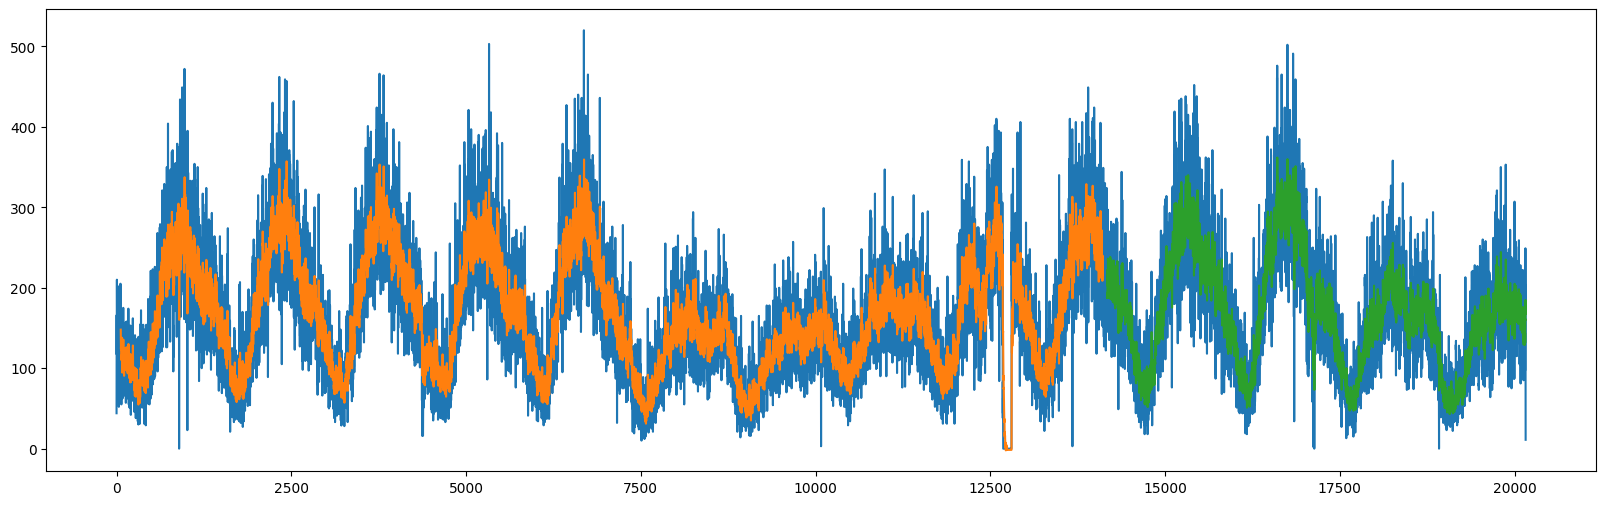

In [19]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,6))
plt.plot(min_max_scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

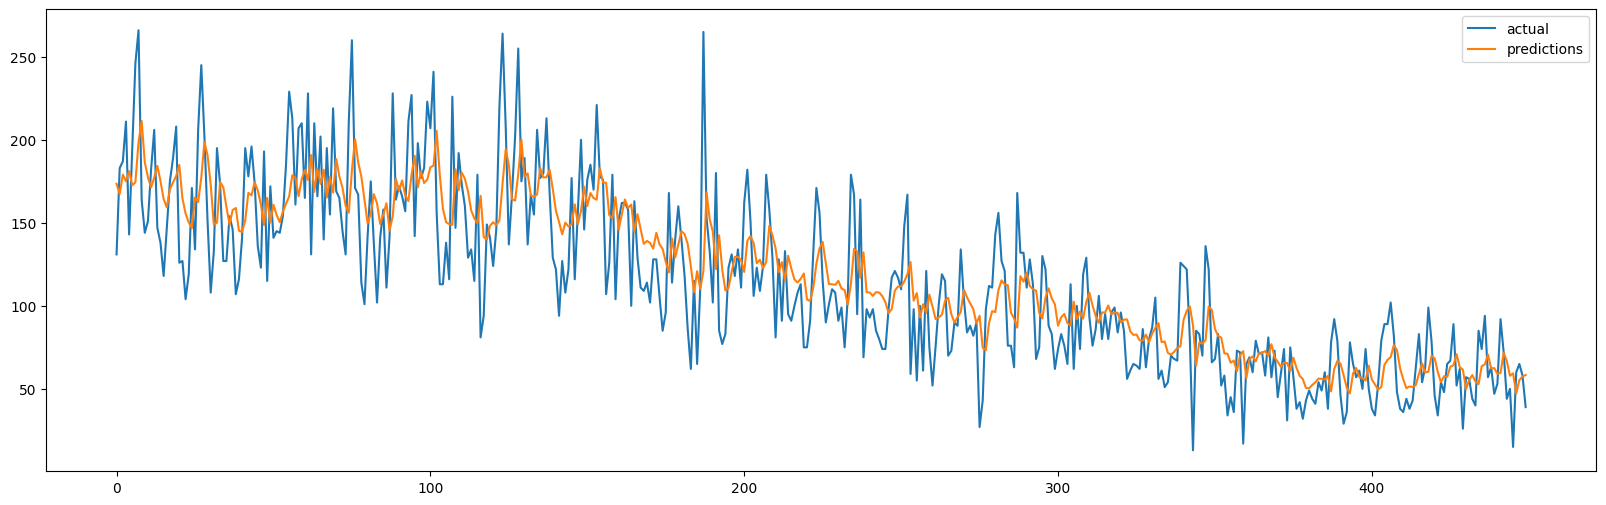

In [20]:
## visualize results
plt.figure(figsize=(20,6))
plt.plot(min_max_scaler.inverse_transform(dataset)[17250:17700], label = 'actual')
plt.plot(testPredictPlot[17250:17700], label = 'predictions')
plt.legend()

>reference: https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


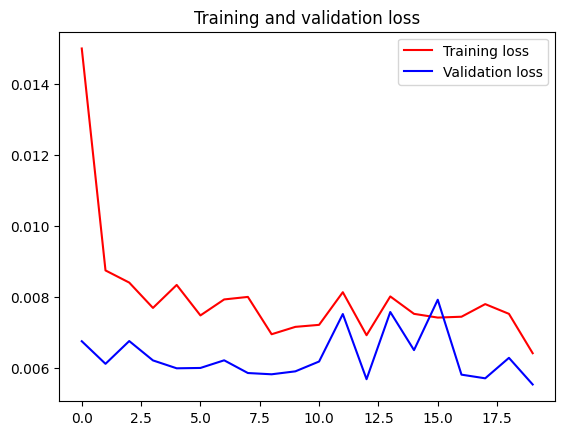

<Figure size 640x480 with 0 Axes>

In [21]:
print(history.history.keys())
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()